In [1]:
from scipy.stats.qmc import LatinHypercube as LHSampler
from matplotlib import pyplot as plt
import numpy as np
from src.utils import plotLHS, concat
from src.eLHS import *

# setup sampler
LHS = LHSampler(d = 2)

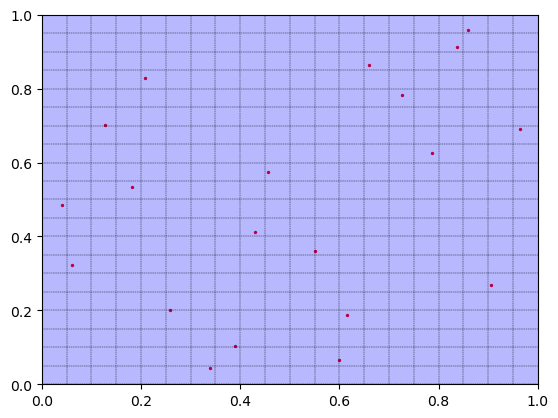

In [2]:
# could be interesting which distribution the PeLHS grade has while varying M and N
N1, M1 = 20, 14
ss2 = LHS.random(N1)
plotLHS(ss2, grid=True, highlight=True)

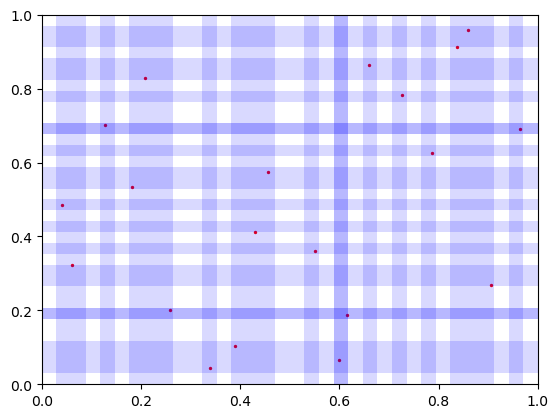

In [3]:
# plotting the partial-eLHS ("Partiale")
pss2 = PartialeLHS(ss2, M1)
plotLHS(pss2, grid=False, highlight=True)

LHS grade: 	 20
PeLHS grade: 	 18
eLHS grade: 	 32
Total Upgrade: 	 14  | Expected:  14  |  ✅


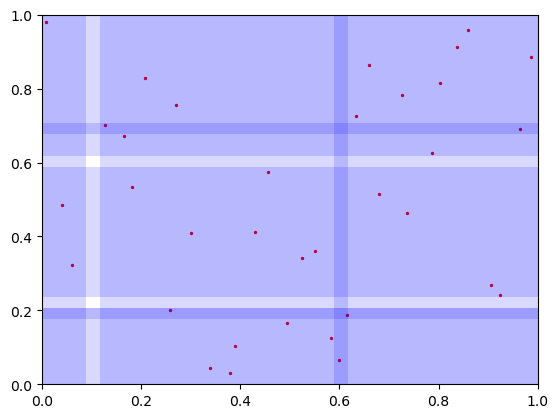

In [4]:
exp = eLHS(ss2, M1)
elhs2 = concat(ss2, exp["expansion"])
plotLHS(elhs2, False, True)

print("LHS grade: \t", lhs_grader(ss2))
print("PeLHS grade: \t", grpss2 := lhs_grader(pss2))
print("eLHS grade: \t", grelhs2 := lhs_grader(elhs2))
print("Total Upgrade: \t" , grelhs2 - grpss2, " | Expected: ", M1, " | ", ("✅" if grelhs2 - grpss2 == M1 else "❌"))

### TEST PLAYGROUND

Limited Sample Size Problem

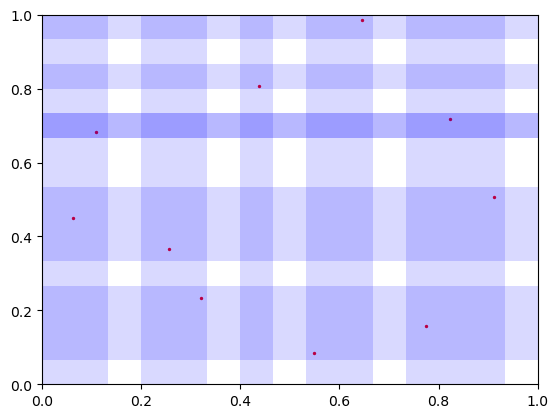

In [99]:
N3, M3 = 10, 5
ss3 = LHS.random(N3)
pss3 = PartialeLHS(ss3, M3)
plotLHS(pss3, False, True)
hbar3 = sudoku_identity(pss3)

In [101]:
# compute a good expansion
ess3 = eLHS(ss3, M3)
ess3

{'F': 5,
 'M': 5,
 'Q': 5,
 'N': 10,
 'expansion': array([[0.49506009, 0.29243583],
        [0.14522299, 0.00689474],
        [0.97324324, 0.63193247],
        [0.39759943, 0.7410144 ],
        [0.68018409, 0.93079912]]),
 'grade': 14}

### Karash-Kuhn-Tucker Solver for LSSP
E pensare che mi ha dato 20...

In [87]:
from scipy.optimize import minimize

# Approx Heaviside step function
def F(t, sharpness = 1000):
    return 0.5 * (1 + np.tanh(sharpness * t))

# Approx Heaviside step function
def H(x):
    return np.where(x < 0, 0, 1)

# Objective Function
def objective(Q):
    return Q[0]

def constraint_eq(Q):
    pass 

def build_constraint_ineq(S: np.ndarray, q, j, alternative = 1, H = H):
    if alternative == 1:
        def constraint_ineq(unknowns):
            Q = unknowns[0]
            N = S.shape[0]
            if q/(N+Q)> 1: 
                return 0
            return -np.sum(H(S[:, j] - q/(N+Q)) * H((q+1)/(N+Q) - S[:, j]) - 1)
        return constraint_ineq
    elif alternative == 2:
        def constraint_ineq(unknowns):
            Q = unknowns[0]
            N = S.shape[0]
            return H(1 - q/(N+Q)) * -(np.sum(H(S[:, j] - q/(N+Q)) * H((q+1)/(N+Q) - S[:, j])) - 1) 
        return constraint_ineq
    

constraint_ineqs = []
for q in range(2 * N3):
    for j in range(ss3.shape[1]):
        constraint_ineqs.append({'type': 'ineq', 'fun': build_constraint_ineq(ss3, q, j, 2)})

# constraint_ineqs.append(
#     {'type': 'ineq', 'fun': lambda Q: Q[0] - 1}
# )
# constraint_ineqs.append(
#     {'type': 'ineq', 'fun': lambda Q: N3 + Q[0]}
# )

initial_guess = [14]

result = minimize(
    objective,
    initial_guess,
    constraints = constraint_ineqs, 
    bounds = [(1, N3-1)], 
    method='SLSQP', 
    tol=1e-6,
    options={
        # 'maxiter': 10000
        'disp': True
    }

)

print(result)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1.0
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 4
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 1.0
       x: [ 1.000e+00]
     nit: 8
     jac: [ 1.000e+00]
    nfev: 8
    njev: 4


In [88]:
# SOLVER STEPPER (for Sample Set ss3)
# Qs = np.linspace(1, N3-1, N3-1)
P = 2 
guessQ = 5
unconsistencies = np.zeros((P))
print("    q j  | passed")
print("    ---  | ------")
for j in range(P):
    for q in range(N3):
        if(constraint_ineqs[q * P + j]['fun']([guessQ]) >= 0):
            print("=> ", q, j, " | ✅")
        else:
            print("=> ", q, j, " | ❌")
            unconsistencies[j] += 1

print("END")

print(unconsistencies)


    q j  | passed
    ---  | ------
=>  0 0  | ✅
=>  1 0  | ✅
=>  2 0  | ✅
=>  3 0  | ✅
=>  4 0  | ✅
=>  5 0  | ✅
=>  6 0  | ✅
=>  7 0  | ❌
=>  8 0  | ✅
=>  9 0  | ✅
=>  0 1  | ✅
=>  1 1  | ❌
=>  2 1  | ✅
=>  3 1  | ✅
=>  4 1  | ✅
=>  5 1  | ✅
=>  6 1  | ✅
=>  7 1  | ✅
=>  8 1  | ✅
=>  9 1  | ✅
END
[1. 1.]


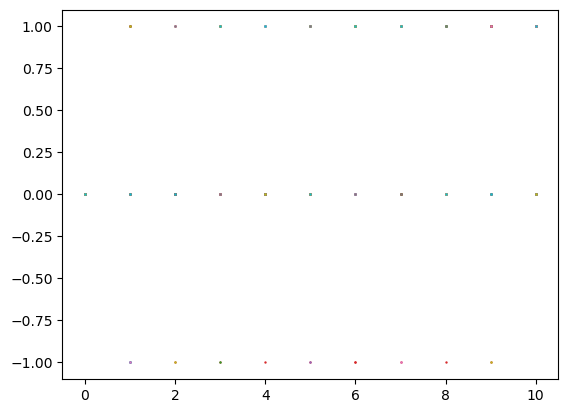

In [89]:
a, b = 0, N3
xs = np.linspace(a, b, N3+1)
for i in range(N3 * 2):
    ys = [constraint_ineqs[i]['fun']([x]) for x in xs]
    # plt.plot(xs, ys)
    plt.scatter(xs, ys, s=0.5)